In [5]:
import tskit
import tszip
import numpy as np
import pandas as pd
import stdpopsim
from numpy.random import default_rng
import msprime
import pyreadr

In [57]:
BCFTOOLS = "/home/kele/programs/bcftools/bcftools-1.11/bcftools"

## Load in the probablistic output of each method
Data frame with one row per site, with every 5 sites represented in this file.
Not sure if it will always be intervals of 5 sites
after the index columns - each (individual) X (haplotype) X (population) has an entry. 

In [12]:
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/RFMix2/rfmix2.fb.tsv'
rfmix_res = pd.read_csv(rf_fb_path, sep = '\t', comment='#')
rfmix_res

,chromosome,physical_position,genetic_position,genetic_marker_index,pop_3-ind_0001:::hap1:::pop_0,pop_3-ind_0001:::hap1:::pop_1,pop_3-ind_0001:::hap1:::pop_2,pop_3-ind_0001:::hap2:::pop_0,pop_3-ind_0001:::hap2:::pop_1,pop_3-ind_0001:::hap2:::pop_2,pop_3-ind_0002:::hap1:::pop_0,pop_3-ind_0002:::hap1:::pop_1,pop_3-ind_0002:::hap1:::pop_2,pop_3-ind_0002:::hap2:::pop_0,pop_3-ind_0002:::hap2:::pop_1,pop_3-ind_0002:::hap2:::pop_2
0,chr22,3847,0.00556,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,chr22,27648,0.03994,5,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,chr22,44787,0.06470,10,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,chr22,61208,0.08841,15,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,chr22,67915,0.09810,20,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,chr22,51233948,74.00755,19975,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3996,chr22,51246694,74.02596,19980,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3997,chr22,51268084,74.05686,19985,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3998,chr22,51275971,74.06826,19990,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


# Mosaic
Data frame with one row per site. 
after the index columns - each (individual) X (haplotype) X (population) has an entry. 

In [47]:
mosaic_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC/la_probabilites.3way_1-2_22-22_1204_60_0.99_100.RData'
mosaic_path2 = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC/localanc_admixed_3way_1-2_22-22_1204_60_0.99_100.RData'

mosaic_res = pyreadr.read_r(mosaic_path)
mr = mosaic_res['arr']
mr = mr.to_dataframe(name = 'boo').reset_index()
mr.pivot_table(index ='dim_2', columns = ['dim_1', 'dim_0'], values = 'boo')

dim_1             0                                 1                      \
dim_0             0         1         2             0         1         2   
dim_2                                                                       
0      2.959188e-05  0.557773  0.442198  1.000000e-08  0.001418  0.998582   
1      2.962302e-05  0.557952  0.442019  1.000000e-08  0.001408  0.998592   
2      2.962302e-05  0.557952  0.442019  1.000000e-08  0.001408  0.998592   
3      2.962302e-05  0.557952  0.442019  1.000000e-08  0.001408  0.998592   
4      2.962302e-05  0.557952  0.442019  1.000000e-08  0.001408  0.998592   
...             ...       ...       ...           ...       ...       ...   
19995  7.505606e-07  0.982599  0.017401  1.000000e-08  0.000804  0.999196   
19996  7.505606e-07  0.982599  0.017401  1.000000e-08  0.000804  0.999196   
19997  7.505606e-07  0.982599  0.017401  1.000000e-08  0.000804  0.999196   
19998  7.505606e-07  0.982599  0.017401  1.000000e-08  0.000804  0.999196   
19999  7.505606e-07  0.982599  0.017401  1.000000e-08  0.000804  0.999196   

dim_1         2                                         3                      
dim_0         0             1             2             0         1         2  
dim_2                                                                          
0      0.999711  4.963064e-06  2.841277e-04  1.938759e-06  0.000206  0.999792  
1      1.000000  1.000000e-08  1.605799e-07  1.000000e-08  0.000204  0.999796  
2      1.000000  1.000000e-08  1.605799e-07  1.000000e-08  0.000204  0.999796  
3      1.000000  1.000000e-08  1.605799e-07  1.000000e-08  0.000204  0.999796  
4      1.000000  1.000000e-08  1.605799e-07  1.000000e-08  0.000204  0.999796  
...         ...           ...           ...           ...       ...       ...  
19995  0.000185  9.997598e-01  5.486441e-05  2.083896e-06  0.000792  0.999206  
19996  0.000185  9.997598e-01  5.486441e-05  2.083896e-06  0.000792  0.999206  
19997  0.000185  9.997598e-01  5.486441e-05  2.083896e-06  0.000792  0.999206  
19998  0.000185  9.997598e-01  5.486441e-05  2.083896e-06  0.000792  0.999206  
19999  0.000185  9.997598e-01  5.486441e-05  2.083896e-06  0.000792  0.999206  

[20000 rows x 12 columns]

# bmix
I am currently missing some sites in the output

also missing BGZIP EOF marker

In [104]:
bmixpath.strip('.gz')

'/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/bmix/bmix.anc.vcf'

In [106]:
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/bmix/bmix.anc.vcf.gz'
!gunzip {bmixpath}
!bgzip {bmixpath.strip('.gz')}
!{BCFTOOLS} index {bmixpath} 

In [105]:
b = pd.read_csv(bmixpath, skiprows=9, sep = '\t')
b

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,pop_3-ind_0001,pop_3-ind_0002
0,chr22,3847,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:1:2:0,0.93,0.07:0,0.01,0.99","0|0:0:2:0.99,0,0.01:0,0,1"
1,chr22,15448,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:1:2:0,0.93,0.07:0,0.01,0.99","0|0:0:2:0.99,0,0.01:0,0,1"
2,chr22,16882,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:1:2:0,0.93,0.07:0,0.01,0.99","1|0:0:2:0.99,0,0.01:0,0,1"
3,chr22,19834,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:1:2:0,0.93,0.07:0,0.01,0.99","0|0:0:2:0.99,0,0.01:0,0,1"
4,chr22,21464,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:1:2:0,0.93,0.07:0,0.01,0.99","0|0:0:2:0.99,0,0.01:0,0,1"
...,...,...,...,...,...,...,...,...,...,...,...
19995,chr22,51292250,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1"
19996,chr22,51292416,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|1:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1"
19997,chr22,51293285,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|1:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1"
19998,chr22,51294013,.,A,T,.,PASS,.,GT:AN1:AN2:ANP1:ANP2,"0|0:1:2:0,1,0:0,0,1","0|0:1:2:0,1,0:0,0,1"


In [79]:
# compare the positions in the bmix results with the positions of all sites?

In [90]:
positions = pd.read_csv('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/site.positions', 
            header = None)
positions[0].values

array([    3847,    15448,    16882, ..., 51293285, 51294013, 51297450])

In [93]:
b.POS.values

array([    3847,    15448,    16882, ..., 51293285, 51294013, 51297450])

In [94]:
set(positions[0].values) - set(b.POS.values)

set()

In [95]:
!{BCFTOOLS} index {bmixpath} 

index: the input is probably truncated, use -f to index anyway: /home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/bmix/bmix.anc.vcf.gz


In [118]:
!{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {bmixpath} > {bmixpath.replace('.vcf.gz', '.csv')}

In [119]:
pd.read_csv(bmixpath.replace('.vcf.gz', '.csv'), header = None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,chr22,3847,0,0.93,0.07,0.0,0.01,0.99,0.99,0.0,0.01,0.0,0.0,1.0,NaN
1,chr22,15448,0,0.93,0.07,0.0,0.01,0.99,0.99,0.0,0.01,0.0,0.0,1.0,NaN
2,chr22,16882,0,0.93,0.07,0.0,0.01,0.99,0.99,0.0,0.01,0.0,0.0,1.0,NaN
3,chr22,19834,0,0.93,0.07,0.0,0.01,0.99,0.99,0.0,0.01,0.0,0.0,1.0,NaN
4,chr22,21464,0,0.93,0.07,0.0,0.01,0.99,0.99,0.0,0.01,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,chr22,51292250,0,1.00,0.00,0.0,0.00,1.00,0.00,1.0,0.00,0.0,0.0,1.0,NaN
19996,chr22,51292416,0,1.00,0.00,0.0,0.00,1.00,0.00,1.0,0.00,0.0,0.0,1.0,NaN
19997,chr22,51293285,0,1.00,0.00,0.0,0.00,1.00,0.00,1.0,0.00,0.0,0.0,1.0,NaN
19998,chr22,51294013,0,1.00,0.00,0.0,0.00,1.00,0.00,1.0,0.00,0.0,0.0,1.0,NaN


In [5]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/full.tsz') 

In [11]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/sample.tsz')


In [8]:
ts.tables.sites

id,position,ancestral_state,metadata
0,11.52230852,0,b''
1,13.98087094,0,b''
2,17.00725012,0,b''
3,53.59884400,0,b''
4,57.65175244,0,b''
5,63.60792050,0,b''
6,126.89208167,0,b''
7,144.26003839,0,b''
8,150.26601148,0,b''
9,154.84132117,0,b''


In [14]:
for tree in ts.trees():
    for site in tree.sites():
        assert len(site.mutations) == 1  # Only supports infinite sites muts.

In [17]:
r = np.load(file = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/true_local_ancestry.site_matrix.npz')['arr']
r.shape

(20000, 4)

In [18]:
r

array([[1, 2, 0, 2],
       [1, 2, 0, 2],
       [1, 2, 0, 2],
       ...,
       [1, 2, 1, 2],
       [1, 2, 1, 2],
       [1, 2, 1, 2]], dtype=int8)

In [13]:
msprime.__version__

'1.0.2'

In [13]:
path2 = '/home/kele/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/la_probabilites.3way_1-2_22-22_1204_60_0.99_100.RData'

result = pyreadr.read_r(path2, 
                       # use_objects=["loaclanc"]
                       )
result

OrderedDict([('arr',
              <xarray.DataArray (dim_0: 3, dim_1: 4, dim_2: 20000)>
              array([[[5.78835197e-03, 5.78305947e-03, 5.77814001e-03, ...,
                       9.42991885e-07, 9.42991885e-07, 9.42991885e-07],
                      [7.50196956e-06, 7.48607410e-06, 7.48297174e-06, ...,
                       3.78644827e-05, 3.78644827e-05, 3.78644827e-05],
                      [9.99500548e-01, 9.99750142e-01, 9.99999716e-01, ...,
                       2.43056421e-04, 2.43056421e-04, 2.43056421e-04],
                      [3.19046761e-04, 3.14161498e-04, 3.09360691e-04, ...,
                       1.14044049e-04, 1.14044049e-04, 1.14044049e-04]],
              
                     [[8.47725965e-01, 8.48558121e-01, 8.49311944e-01, ...,
                       9.91391038e-01, 9.91391038e-01, 9.91391038e-01],
                      [1.61227473e-02, 1.60330609e-02, 1.60250186e-02, ...,
                       6.90445000e-04, 6.90445000e-04, 6.90445000e-04],
       

In [19]:
result = pyreadr.read_r(path2, 
                       use_objects=["arr"]
                       )
result['arr'][:, : , 0:3].sum('dim_0')
# ancestries * haploid chromosomes * sites 

<xarray.DataArray (dim_1: 4, dim_2: 3)>
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])
Dimensions without coordinates: dim_1, dim_2

In [33]:
anc_prob.data[anc_prob.data>threshold].shape

(78169,)

In [38]:
threshold = 0.9
anc_prob = result['arr'].data.copy()
anc_prob[anc_prob>threshold,] = 1
anc_prob[anc_prob<=threshold] = 0
anc_calls = anc_prob.astype(int)
anc_calls.shape

(3, 4, 20000)

In [25]:
# over mean ancestries (over individuals)
result['arr'][:, : , 0:3].mean(['dim_1', 'dim_2'])


<xarray.DataArray (dim_0: 3)>
array([0.25146375, 0.21700147, 0.53153478])
Dimensions without coordinates: dim_0

In [15]:
import pandas as pd
import numpy as np
PATH = "/home/kele/Documents/lai/lai-sim/results/RFMix2/AmericanAdmixture_4B11/AA_42/short_run.rfmix2.fb.tsv"
lai = pd.read_csv(PATH, comment = '#', sep = '\t')
lai = lai.set_index(['chromosome',  'genetic_position', 'genetic_marker_index'])
lai = lai.melt(id_vars = ['physical_position'])
threshold =.9
lai[['name', 'hap', 'pop']] = lai['variable'].str.split(':::', expand=True)
lai['calls'] = lai['value'] > threshold

calls = lai.pivot_table(index = ['physical_position', 'name', 'hap', 'pop'], values = 'calls').reset_index()
lai_calls = calls.query('calls == True').pivot(index = ['physical_position'], columns = ['name', 'hap', 'calls'])
lai_calls = lai_calls.replace('pop_0', 0).replace('pop_1', 1).replace('pop_2', 2).replace('pop_3', 3).replace(np.NaN, -1).astype(int)

haploid_calls_1 = lai_calls.values[:, ::2]
haploid_calls_2 = lai_calls.values[:, 1::2]

highpop = np.maximum(lai_calls.values[:, ::2], lai_calls.values[:, 1::2])
lowpop = np.minimum(lai_calls.values[:, ::2], lai_calls.values[:, 1::2])

lai_calls_diploid = lowpop + highpop*10

In [16]:
lai_calls.columns.get_level_values(1).values[::2]

array(['pop_3-ind_0001', 'pop_3-ind_0002'], dtype=object)

In [5]:
# save as numpy vs hdf

In [11]:
np.save(file = '/home/kele/save_test.npy', arr = lai_calls_diploid)
np.savez_compressed(file = '/home/kele/save_test.npz', arr = lai_calls_diploid)

In [39]:
df = pd.DataFrame(lai_calls_diploid)
df.index = lai_calls.index
df.columns = lai_calls.columns.get_level_values(1).values[::2]
df.to_hdf('/home/kele/save_test.h5', key = 'la', mode = 'w', 
          complib = 'blosc:lz4hc', complevel = 9)

In [38]:
lai.sort_values([ 'physical_position', 'pop', 'name', 'hap', ])

,physical_position,variable,value,name,hap,pop,calls
0,2096,pop_3-ind_0001:::hap1:::pop_0,0.0,pop_3-ind_0001,hap1,pop_0,False
12000,2096,pop_3-ind_0001:::hap2:::pop_0,0.0,pop_3-ind_0001,hap2,pop_0,False
24000,2096,pop_3-ind_0002:::hap1:::pop_0,1.0,pop_3-ind_0002,hap1,pop_0,True
36000,2096,pop_3-ind_0002:::hap2:::pop_0,0.0,pop_3-ind_0002,hap2,pop_0,False
4000,2096,pop_3-ind_0001:::hap1:::pop_1,1.0,pop_3-ind_0001,hap1,pop_1,True
...,...,...,...,...,...,...,...
43999,51293285,pop_3-ind_0002:::hap2:::pop_1,0.0,pop_3-ind_0002,hap2,pop_1,False
11999,51293285,pop_3-ind_0001:::hap1:::pop_2,0.0,pop_3-ind_0001,hap1,pop_2,False
23999,51293285,pop_3-ind_0001:::hap2:::pop_2,1.0,pop_3-ind_0001,hap2,pop_2,True
35999,51293285,pop_3-ind_0002:::hap1:::pop_2,0.0,pop_3-ind_0002,hap1,pop_2,False


In [37]:
lai.sort_values([ 'physical_position', 'pop', 'name', 'hap', ])['value'].values.reshape((-1, 3,4))[3]

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 1.]])

# how to convert these LAI intervals used by RFmix2 into the LA at each site 

In [81]:
plinkmap = pd.read_csv('/home/kele/Dropbox/Documents/lai/lai-sim/results/local_ancestry/AmericanAdmixture_4B11/AA_42/short_run.plink_map.txt', 
                      sep = '\t', header = None)
plinkmap.columns = ['chr', 'id', 'gpos', 'bp']
plinkmap.head()

,chr,id,gpos,bp
0,chr22,.,0.003028,2096
1,chr22,.,0.020609,14267
2,chr22,.,0.031071,21510
3,chr22,.,0.038986,26989
4,chr22,.,0.039562,27388


In [83]:
lai = pd.read_csv(PATH, comment = '#', sep = '\t')
bins_left = lai['genetic_marker_index'].values
bins_right = lai['genetic_marker_index'][1:].values
# add the final bin
bins_right = np.concatenate([bins_right, [plinkmap.index.values[-1]+1]])

site_indexes = plinkmap.index.values[:,None]
mask = (bins_left <= site_indexes) & (bins_right > site_indexes)

mask.shape

(20000, 4000)

In [86]:
# CRF index of each site
crf_of_site = np.where(mask)[1]
len(crf_of_site)

20000

# LA at each site

In [115]:
lai_sites = lai.iloc[crf_of_site].copy()
lai_sites['bp'] = plinkmap['bp'].values
lai_sites['gpos'] = plinkmap['gpos'].values
lai_sites = lai_sites.drop(['physical_position', 'genetic_marker_index', 'chromosome', 'genetic_position'], axis = 1)

lai_sites = lai_sites.melt(id_vars = ['bp', 'gpos'])
lai_sites[['name', 'hap', 'pop']] = lai_sites['variable'].str.split(':::', expand=True)
lai_sites = lai_sites.drop(['variable'], axis = 1)
lai_sites

,bp,gpos,value,name,hap,pop
0,2096,0.003028,0.0,pop_3-ind_0001,hap1,pop_0
1,14267,0.020609,0.0,pop_3-ind_0001,hap1,pop_0
2,21510,0.031071,0.0,pop_3-ind_0001,hap1,pop_0
3,26989,0.038986,0.0,pop_3-ind_0001,hap1,pop_0
4,27388,0.039562,0.0,pop_3-ind_0001,hap1,pop_0
...,...,...,...,...,...,...
239995,51293285,74.093267,1.0,pop_3-ind_0002,hap2,pop_2
239996,51293990,74.094285,1.0,pop_3-ind_0002,hap2,pop_2
239997,51294013,74.094319,1.0,pop_3-ind_0002,hap2,pop_2
239998,51295267,74.096130,1.0,pop_3-ind_0002,hap2,pop_2


In [221]:
# sites * pops * haps
lai_mat = lai_sites.sort_values(['bp', 'pop', 'name', 'hap', ])['value'].values.reshape(-1, 3, 4)
lai_mat.shape

(20000, 3, 4)

In [223]:
lai_mat.sum((1,2)).max(), lai_mat.sum((1,2)).min()

(4.0, 3.9999999999999996)

In [224]:
site_matrix_path = "/home/kele/Documents/lai/lai-sim/results/local_ancestry/AmericanAdmixture_4B11/AA_42/short_run.true_local_ancestry.site_matrix.npz"
loaded = np.load(site_matrix_path)
site_matrix = loaded['arr']
site_matrix.shape

admixed_true = site_matrix[:, -4:]
admixed_true.shape

(20000, 4)

In [288]:
admixed_true

array([[1, 2, 0, 2],
       [1, 2, 0, 2],
       [1, 2, 0, 2],
       ...,
       [1, 2, 1, 2],
       [1, 2, 1, 2],
       [1, 2, 1, 2]])

In [303]:
values = admixed_true.T
n_values = np.max(values) + 1
true_la_site = np.eye(n_values)[values]
true_la_site = np.transpose(true_la_site, axes = [1, 2, 0])
true_la_site.shape

(20000, 3, 4)

In [304]:
true_la_site.sum((1,2)).max(), true_la_site.sum((1,2)).min()

(4.0, 4.0)

In [305]:
((lai_mat - true_la_site)**2).mean()

0.006292100771454168

In [306]:
# compare the sums of the two haploids for 

In [307]:
lat_mat_diploid = lai_mat[:,:,::2] + lai_mat[:,:,1::2]
true_la_diploid = true_la_site[:,:,::2] + true_la_site[:,:,1::2]

In [308]:
# and with MOSAIC

In [309]:
((lat_mat_diploid - true_la_diploid)**2).mean()

0.012459600418375003

In [310]:
import pyreadr
import xarray

path = "/home/kele/Dropbox/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/la_probabilites.3way_1-2_22-22_1204_60_0.99_100.RData"
result = pyreadr.read_r(path, 
                        use_objects=["arr"]
                       )
arr = result['arr']
mosiac_res = np.transpose(arr.values, axes = [2, 0, 1])

In [311]:
mosiac_res_diploid = mosiac_res[:,:,::2] + mosiac_res[:,:,1::2]
((mosiac_res_diploid - true_la_diploid)**2).mean()

0.02432614219151574

In [312]:
# difference in haploids - due to rephasing? 
((mosiac_res - true_la_site)**2).mean()

0.19282205788785042

# the two inferred local ancestries agree

In [313]:
((mosiac_res_diploid - lat_mat_diploid)**2).mean()

0.026251595376231316

In [42]:
pd.read_hdf("/home/kele/Dropbox/Documents/lai/lai-sim/results/RFMix2/AmericanAdmixture_4B11/AA_42/short_run/diploid_la.hdf")

,pop_3-ind_0001,pop_3-ind_0002
physical_position,,
2096,21,20
27648,21,20
41526,21,20
59291,21,20
65860,21,20
...,...,...
51213829,21,21
51244587,21,21
51259158,21,21


In [25]:
np.histogram(lai.value)#.groupby('physical_position').size()

(array([31920,    41,    16,    17,     6,     6,    17,    16,    41,
        15920]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
# trying to load the results from mosaic

In [8]:
import pyreadr
import xarray

path = "/home/kele/Dropbox/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/la_probabilites.3way_1-2_22-22_1204_60_0.99_100.RData"
result = pyreadr.read_r(path, 
                        use_objects=["arr"]
                       )
arr = result['arr']

In [13]:
arr.values.reshape(12, 20000)

array([[5.78835197e-03, 5.78305947e-03, 5.77814001e-03, ...,
        9.42991885e-07, 9.42991885e-07, 9.42991885e-07],
       [7.50196956e-06, 7.48607410e-06, 7.48297174e-06, ...,
        3.78644827e-05, 3.78644827e-05, 3.78644827e-05],
       [9.99500548e-01, 9.99750142e-01, 9.99999716e-01, ...,
        2.43056421e-04, 2.43056421e-04, 2.43056421e-04],
       ...,
       [9.83869751e-01, 9.83959453e-01, 9.83967498e-01, ...,
        9.99271691e-01, 9.99271691e-01, 9.99271691e-01],
       [3.96544472e-04, 1.98375462e-04, 2.43716933e-07, ...,
        8.44028122e-04, 8.44028122e-04, 8.44028122e-04],
       [9.96273667e-01, 9.96324024e-01, 9.96373407e-01, ...,
        9.99095623e-01, 9.99095623e-01, 9.99095623e-01]])

In [9]:
arr.values.shape

(3, 4, 20000)

In [4]:
path = '/home/kele/Dropbox/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC_RESULTS/localanc_admixed_3way_1-2_22-22_1204_60_0.99_100.RData'
path2 = '/home/kele/Dropbox/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC_RESULTS/admixed_3way_1-2_22-22_1204_60_0.99_100.RData'
path3 = "/home/kele/save_test.RData"

In [5]:
pyreadr.list_objects(path3)

PyreadrError: File /home/kele/save_test.RData does not exist!

In [8]:
result = pyreadr.read_r(path3, 
                        use_objects=["arr"]
                       )
arr = result['arr']

In [12]:
arr.values.shape

(3, 4, 20000)

In [58]:
pyreadr.list_objects(path2)

[{'object_name': 'target', 'columns': []},
 {'object_name': 'logfile', 'columns': []},
 {'object_name': 'Mu', 'columns': []},
 {'object_name': 'theta', 'columns': []},
 {'object_name': 'rho', 'columns': []},
 {'object_name': 'A', 'columns': []},
 {'object_name': 'NUMA', 'columns': []},
 {'object_name': 'nchrno', 'columns': []},
 {'object_name': 'chrnos', 'columns': []},
 {'object_name': 'dr', 'columns': []},
 {'object_name': 'NL', 'columns': []},
 {'object_name': 'kLL', 'columns': []},
 {'object_name': 'GpcM', 'columns': []}]

In [56]:
result = pyreadr.read_r(path2, 
                       # use_objects=["loaclanc"]
                       )
result

OrderedDict([('target',
                  target
              0  admixed),
             ('logfile',
                                                           logfile
              0  MOSAIC_RESULTS/admixed_3way_1-2_22-22_1204_60_...),
             ('Mu',
                            0             1             2
              pop_0  0.962023  2.218161e-21  2.630498e-21
              pop_1  0.032365  9.717704e-01  3.400345e-02
              pop_2  0.005612  2.822957e-02  9.659966e-01),
             ('theta',
                    theta
              0  0.000202
              1  0.000202
              2  0.000202),
             ('rho',
                     rho
              0  0.02964
              1  0.02964
              2  0.02964),
             ('A',
                   A
              0  3.0),
             ('NUMA',
                 NUMA
              0     4),
             ('nchrno',
                 nchrno
              0       1),
             ('chrnos',
                 chrnos
    

In [43]:
result.keys()

odict_keys(['target', 'logfile', 'Mu', 'theta', 'rho', 'A', 'NUMA', 'nchrno', 'chrnos', 'dr', 'NL', 'kLL', 'GpcM'])

In [ ]:

#return(100/4*log(abs((1+2*rcmb)/(1-2*rcmb))))

In [7]:
rcmb = .3
100/4*np.log(np.abs((1+2*rcmb)/(1-2*rcmb)))

34.657359027997266

In [9]:
100 * 1/4 * np.log(np.abs((1+2*rcmb)/(1-2*rcmb)))

34.657359027997266

In [10]:
np.log(np.abs((1+2*rcmb)/(1-2*rcmb)))

1.3862943611198906

In [20]:
d_M = 34.6/100

d_M, (np.e**(4*d_M)-1) / 2*(np.e**(-4*d_M)+1)

(0.34600000000000003, 1.8701294134320061)

In [26]:
r = np.tanh(2*d_M)/2
r

0.2996326495315751

In [27]:
def r_of_cM(cM):
    M = cM/100
    r = np.tanh(2*M)/2
    return(r)

In [42]:
df = pd.read_csv('/home/kele/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/test_anal_1/input/snpfile.22.BAK', 
 header = None, sep = ' ', skipinitialspace=True               )
df[2] = df[2].apply(r_of_cM)
df.to_csv('/home/kele/Documents/lai/lai-sim/results/MOSAIC/AmericanAdmixture_4B11/AA_42/test_anal_1/input/snpfile.22', 
         index = None, sep = ' ', header = None, float_format = '{:.8f}'.format)

In [29]:
r_of_cM(900)

0.4999999999999998

In [70]:
seq_lengths = np.geomspace(1e4, 1e9, num = 80).astype(int)
seq_lengths

array([     10000,      11568,      13383,      15483,      17912,
            20723,      23974,      27735,      32086,      37121,
            42944,      49682,      57476,      66494,      76926,
            88995,     102957,     119110,     137797,     159415,
           184426,     213360,     246834,     285559,     330359,
           382189,     442149,     511517,     591768,     684609,
           792016,     916273,    1060025,    1226330,    1418726,
          1641307,    1898807,    2196707,    2541343,    2940048,
          3401304,    3934927,    4552268,    5266462,    6092704,
          7048574,    8154407,    9433732,   10913767,   12626001,
         14606863,   16898497,   19549661,   22616759,   26165046,
         30270016,   35019004,   40513049,   46869041,   54222210,
         62728998,   72570396,   83955786,   97127401,  112365480,
        129994222,  150388694,  173982805,  201278537,  232856629,
        269388930,  311652694,  360547115,  417112461,  482552

In [71]:
from IPython.display import SVG
import matplotlib.pyplot as plt

seq_lengths = np.linspace(1e4, 1e9, num = 80).astype(int)
seq_lengths = np.geomspace(1e4, 1e9, num = 80).astype(int)

res = []
for sl in seq_lengths:
    ts = msprime.sim_ancestry(
        samples = 2, 
        ploidy = 1, 
        population_size = 1000,
        sequence_length = sl, 
        discrete_genome = True, 
        recombination_rate = 1/sl)
    mts = msprime.sim_mutations(ts, rate=1e-8)
    res.append([sl, mts.num_sites, mts.num_trees])

In [72]:
mts.num_trees

1347

[]

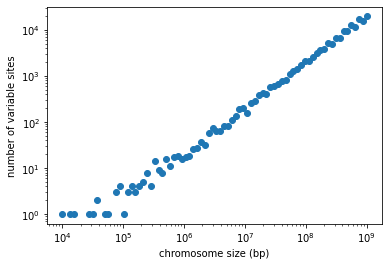

In [74]:
plt.scatter(np.array(res)[:,0], np.array(res)[:,1])
plt.xlabel('chromosome size (bp)')
plt.ylabel('number of variable sites')
plt.semilogy()
plt.semilogx()



Text(0, 0.5, 'number of gene trees')

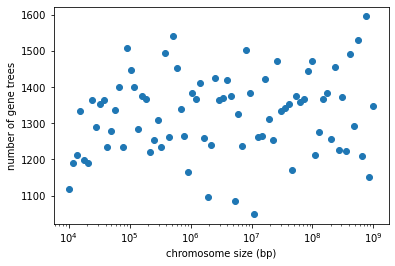

In [77]:
plt.scatter(np.array(res)[:,0], np.array(res)[:,2])
plt.semilogx()
plt.xlabel('chromosome size (bp)')
plt.ylabel('number of gene trees')

[]

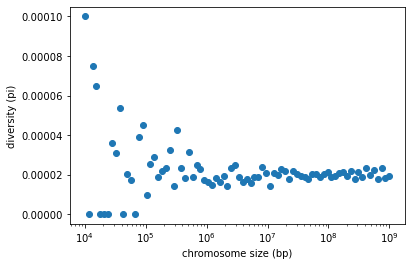

In [83]:
plt.scatter(np.array(res)[:,0], np.array(res)[:,1]/np.array(res)[:,0])
plt.xlabel('chromosome size (bp)')
plt.ylabel('diversity (pi)')
#plt.semilogy()
plt.semilogx()


In [3]:
path = "/home/kele/Documents/lai/lai-sim/results/simulations/AmericanAdmixture_4B11/AA_42/test_anal_1.sample.filter.tsz"
ts = tszip.decompress(path)

print(len(ts.samples()))
ts


400


In [10]:
!/home/kele/programs/bcftools/bcftools-1.11/bcftools view \
/home/kele/Documents/lai/lai-sim/results/local_ancestry/AmericanAdmixture_4B11/AA_42/test_anal_1.phased.target_inds.vcf.gz | \
  grep "|"  | sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/2/g' | sed 's/1|1/3/g' 
  

[W::vcf_parse] Contig 'chr22' is not defined in the header. (Quick workaround: index the file with tabix.)
chr22	1965	.	A	T	.	PASS	.	GT	0	2	0	0	0	0	0	0	3	0	0	0	0	0	0	0	0	1	0	0	0	3	0	2	0	2	1	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	1	0	0	0	0
chr22	5853	.	A	T	.	PASS	.	GT	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
chr22	8418	.	A	T	.	PASS	.	GT	0	0	0	0	0	0	0	0	0	0	0	3	0	0	2	1	2	0	0	0	1	0	0	0	2	0	2	2	0	0	1	3	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
chr22	9857	.	A	T	.	PASS	.	GT	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	0	0	0	0
chr22	10635	.	A	T	.	PASS	.	GT	0	0	0	1	2	0	0	0	0	2	0	0	1	0	0	0	1	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	0	0	0	3	0	0
chr22	11416	.	A	T	.	PASS	.	GT	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
chr22	14419	.	A	T	.	PASS	.	GT	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	2	0	0	3	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0

In [1]:
import stdpopsim
chrom_id ='chr22'
chr_len = 1

species = stdpopsim.get_species("HomSap")
contig = species.get_contig(chrom_id, length_multiplier=chr_len)

In [2]:
contig.recombination_map.get_length()


51304566.0

In [ ]:
import stdpopsim
chrom_id ='chr22'
chr_len = .25

species = stdpopsim.get_species("HomSap")
contig = species.get_contig(chrom_id, length_multiplier=chr_len)
contig.recombination_map.get_length()


In [45]:
chrom_id ='chr22'
chr_len = .05

species = stdpopsim.get_species("HomSap")
contig = species.get_contig(chrom_id, length_multiplier=chr_len)

positions = [99, 12345, 421435]
rate = contig.recombination_map.get_ll_recombination_map().get_rates()[0] * 100 # convert to cM
cM_pos = [pos*rate for pos in positions]


In [52]:
contig.recombination_map.get_rates()

[1.4445022767788226e-08, 0.0]

In [24]:
pd.read_csv('/home/kele/Documents/lai/lai-sim/results/local_ancestry/AmericanAdmixture_4B11/AA_42/test_anal_1.genetic_map.txt',
           sep = '\t', header = None)[2].values

array([2.838000e-03, 8.455000e-03, 1.216000e-02, 1.423800e-02,
       1.536200e-02, 1.649000e-02, 2.082800e-02, 2.509400e-02,
       2.910800e-02, 3.193800e-02, 3.247800e-02, 3.385600e-02,
       4.250700e-02, 4.723800e-02, 5.096300e-02, 5.618500e-02,
       6.012500e-02, 6.073000e-02, 6.110000e-02, 7.280000e-02,
       7.415900e-02, 7.760400e-02, 8.319300e-02, 8.456700e-02,
       8.724900e-02, 8.927600e-02, 9.206800e-02, 9.291800e-02,
       9.852200e-02, 1.001040e-01, 1.014170e-01, 1.063470e-01,
       1.067760e-01, 1.069080e-01, 1.106680e-01, 1.127350e-01,
       1.355880e-01, 1.365560e-01, 1.371990e-01, 1.394070e-01,
       1.403310e-01, 1.428500e-01, 1.447030e-01, 1.468760e-01,
       1.562990e-01, 1.583460e-01, 1.625570e-01, 1.677170e-01,
       1.682310e-01, 1.696030e-01, 1.715870e-01, 1.719460e-01,
       1.726500e-01, 1.748820e-01, 1.780380e-01, 1.821760e-01,
       1.829950e-01, 1.921560e-01, 1.930490e-01, 1.962330e-01,
       1.963400e-01, 1.967820e-01, 1.997930e-01, 2.0889

In [25]:
!pwd

/home/kele/Documents/lai/lai-sim/workflow/notebooks


In [46]:
stdpopsim.__version__

'0.1.2'

In [44]:
rate

1.4445022767788225e-06

In [3]:
def get_local_ancestry(ts, admixture_time, per_batch):
    # target_samples are at time==0
    target_samples = np.intersect1d(
                ts.samples(),
                np.where(ts.tables.nodes.asdict()['time']==0)[0]
            )
    # target ancestors are at time==admixture_time
    target_ancestors = np.where(ts.tables.nodes.asdict()['time']==admixture_time)[0]
    
    nsample = len(target_samples)
    l = [x for x in range(0, nsample, per_batch)]
    r = [x for x in range(per_batch, nsample+per_batch, per_batch)]
    #print(l, r)
    dfs = []
    for i in range(len(l)):
        local = ts.tables.link_ancestors(          
            samples = target_samples[l[i]:r[i]],
            ancestors = target_ancestors
        )

        local_df = pd.DataFrame({
            'left': local.left, 
            'right': local.right,
            'parent': local.parent,
            'child': local.child
        })
        
        dfs.append(local_df)
        
    local_ancestry_df = pd.concat(dfs)
    pop_of_node = dict(zip(range(len(ts.tables.nodes)), ts.tables.nodes.population))
    # local ancestry population
    local_ancestry_df['localpop'] = [pop_of_node[x] for x in local_ancestry_df['parent']]
    # sampling population
    local_ancestry_df['samplepop'] = [pop_of_node[x] for x in local_ancestry_df['child']]
    local_ancestry_df = local_ancestry_df.sort_values(['samplepop', 'child', 'left']).reset_index(drop=True)
    return(local_ancestry_df)

In [3]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/simulations/AmericanAdmixture_4B11/AA_42/test_anal_1.sample.tsz')

print(len(ts.samples()))
ts

175114


In [37]:
tables = ts.tables
#tables.sites.ancestral_state = np.array(['A' for _ in tables.sites])
a, off = tskit.pack_strings(['A' for _ in tables.sites])
tables.sites.set_columns(position = tables.sites.position, ancestral_state = a, ancestral_state_offset = off)

t, off = tskit.pack_strings(['T' for _ in tables.mutations])

tables.mutations.set_columns(site=tables.mutations.site, 
                             node=tables.mutations.node, 
                             derived_state=a, 
                             derived_state_offset=off)

In [35]:
tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,438874,nan,T,-1,
1,1,13803,nan,T,-1,
2,2,278061,nan,T,-1,
3,3,346536,nan,T,-1,
4,4,177489,nan,T,-1,
5,5,281830,nan,T,-1,
6,6,351117,nan,T,-1,
7,7,146593,nan,T,-1,
8,8,49747,nan,T,-1,
9,9,283152,nan,T,-1,


In [12]:
[s.position for s in ts.sites()]

[1.2742944359779358,
 42.79837908688933,
 73.14186565345153,
 77.70543927233666,
 166.39498272514902,
 212.2924223949667,
 229.60578837851062,
 239.33020239695907,
 253.95831123087555,
 312.8965358028654,
 453.7063127136789,
 455.2432009463664,
 458.3674761727452,
 529.4313842137344,
 545.71736064367,
 599.1509334724396,
 646.1419532359578,
 686.763868689537,
 695.3500957749784,
 746.4046758699697,
 771.8510902135167,
 799.5224416851997,
 821.7596545377746,
 931.0459000070114,
 943.0218509614933,
 985.9024206802715,
 1025.9012150326744,
 1206.3463911088184,
 1281.6836734134704,
 1289.653668596875,
 1297.2256690599024,
 1338.5502100337762,
 1345.5442794265691,
 1351.3077791603282,
 1360.7574570556171,
 1369.024188055424,
 1382.8181520248763,
 1388.6979620996863,
 1423.6273282323964,
 1515.3275527425576,
 1523.703059512889,
 1553.7801657780074,
 1599.2533378293738,
 1638.2902904902585,
 1710.5155942104757,
 1742.9543086886406,
 1867.660406040959,
 1961.7500392948277,
 1965.4399013072252,

In [4]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/simulations/AmericanAdmixture_4B11/AA_42/test_anal_1.sample.filter.tsz')

print(len(ts.samples()))
ts

400


In [67]:
la = get_local_ancestry(ts, admixture_time=20, per_batch=12)
la

34


,left,right,parent,child,localpop,samplepop
0,0.0,1032662.0,17588,0,0,0
1,1032662.0,1502117.0,18959,0,0,0
2,1502117.0,1502437.0,2220,0,0,0
3,1502437.0,2065843.0,18959,0,0,0
4,2065843.0,2066010.0,14009,0,0,0
...,...,...,...,...,...,...
1940,73718.0,681222.0,61532,399,1,3
1941,681222.0,681617.0,57704,399,1,3
1942,681617.0,707838.0,61532,399,1,3
1943,707838.0,708216.0,57704,399,1,3


In [70]:
la.to_hdf('./temp.hdf', key = 'local_ancestry', mode = 'w', complib = 'blosc:lz4', format ='fixed')

/home/kele/Documents/lai/lai-sim/workflow/notebooks


ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

In [52]:
len(np.where(ts.tables.nodes.asdict()['time']==0)[0])

400

In [53]:
ts.tables.nodes.asdict()['time'][ts.samples()]

array([ 0.,  0.,  0., ..., 20., 20., 20.])

In [54]:
len(ts.samples())

175114

In [30]:
random_seed = 42


rng = default_rng(random_seed)
seeds = rng.bit_generator._seed_seq.spawn(10)

In [32]:
type(seeds)

list

In [27]:
rng = np.random.default_rng(seed)
rng.choice(range(9), 3, replace=False)

array([1, 3, 0])

In [28]:
rng.choice(range(9), 3, replace=False)

array([4, 3, 0])

In [29]:
rng.choice(range(9), 3, replace=False)

array([3, 0, 8])

In [3]:
ts = tszip.decompress('/home/kele/Documents/lai/lai-sim/results/sims/AmericanAdmixture_4B11/AA_42.full.tsz')

In [4]:
ts

In [22]:
take = np.array([], dtype = int)
per_pop = 14
for pop in ts.populations():
    samples = ts.samples(population = pop.id)[:per_pop]
    take = np.concatenate([take, samples])

In [23]:
take

array([     0,      1,      2,      3,      4,      5,      6,      7,
            8,      9,     10,     11,     12,     13,  28948,  28949,
        28950,  28951,  28952,  28953,  28954,  28955,  28956,  28957,
        28958,  28959,  28960,  28961,  91804,  91805,  91806,  91807,
        91808,  91809,  91810,  91811,  91812,  91813,  91814,  91815,
        91816,  91817, 174744, 174745, 174746, 174747, 174748, 174749,
       174750, 174751, 174752, 174753, 362754, 362755, 362756, 362757])

In [27]:
take[::2]

array([     0,      2,      4,      6,      8,     10,     12,  28948,
        28950,  28952,  28954,  28956,  28958,  28960,  91804,  91806,
        91808,  91810,  91812,  91814,  91816, 174744, 174746, 174748,
       174750, 174752, 362754, 362756])

In [24]:
simp_ts = ts.simplify(
    samples=take, 
    map_nodes=True, 
    filter_populations=False
)

In [26]:
simp_ts[0]

In [57]:
[1,1,3,4][-1:]

[4]

In [47]:
from numpy.random import default_rng
random_seed = 42
rng = default_rng(random_seed)

def sample_inds(ts, pop_id, nind):
    """return the haploid sample ids representing sampling nind individuals from pop_id in ts"""
    hap_samples = ts.samples(population = pop.id)
    # sample from the first haploids of each ind
    take = rng.choice(hap_samples[::2], nind, replace=False)
    samples = np.empty(nind*2, dtype=int)
    samples[0::2] = take
    samples[1::2] = take+1
    return(samples)
    

sample_inds(ts, 3, 18), sample_inds(ts, 2, 18)

(array([371680, 371681, 437354, 437355, 376066, 376067, 372022, 372023,
        443206, 443207, 441892, 441893, 408372, 408373, 464192, 464193,
        417488, 417489, 407764, 407765, 416116, 416117, 372536, 372537,
        439250, 439251, 430796, 430797, 452014, 452015, 383692, 383693,
        435252, 435253, 444488, 444489]),
 array([409088, 409089, 441564, 441565, 441766, 441767, 379922, 379923,
        428418, 428419, 451974, 451975, 433238, 433239, 455616, 455617,
        391518, 391519, 435580, 435581, 463678, 463679, 443688, 443689,
        369806, 369807, 448788, 448789, 382984, 382985, 369378, 369379,
        400588, 400589, 399606, 399607]))

In [61]:
a = sample_inds(ts, 2, 18)
a.sort()
a

array([378580, 378581, 379510, 379511, 380026, 380027, 387572, 387573,
       394098, 394099, 402364, 402365, 409136, 409137, 410760, 410761,
       414278, 414279, 414454, 414455, 414836, 414837, 425890, 425891,
       428288, 428289, 433842, 433843, 435144, 435145, 437292, 437293,
       456378, 456379, 460274, 460275])

In [ ]:
c = np.empty((a.size + b.size), dtype=a.dtype)
c[0::2] = a
c[1::2] = b

In [50]:
import os 
import pandas as pd

In [28]:
np.empty(4)

array([4.66610009e-310, 0.00000000e+000, 6.92363728e-310, 6.92353203e-310])

In [52]:
os.chdir('/home/kele/Documents/lai/lai-sim')

In [53]:
config= dict()
config["simulations"] = 'config/simulations.tsv'
config["analyses"] =  'config/analyses.tsv'

In [55]:
# this file has one line per base simulation run
# up through the recap and mutate step
simulations = pd.read_csv(config["simulations"], sep="\t")
analyses = pd.read_csv(config["analyses"], sep="\t")
units = analyses.merge(simulations, on=['sim_name'])
units

,anal_name,sim_name,nsamp_admixed,nsamp_ref,MAC_filter,max_snps,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
0,test_anal_1,AA_42,50,50,5,10000,AmericanAdmixture_4B11,42,workflow/scripts/sim/SLiM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [44]:
next(simulations.itertuples()).sim_name

'AA_42'

In [45]:
simulations

,sim_name,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
sim_name,,,,,,,,
AA_42,AA_42,AmericanAdmixture_4B11,42,../workflow/scripts/sim/SliM/AmericanAdmixture...,7310,1.440000e-08,chr22,0.25
AA_52,AA_52,AmericanAdmixture_4B11,52,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [46]:
[f'results/sims/{s.model_name}/{s.sim_name}.full.tsz' for s in simulations.itertuples()]

['results/sims/AmericanAdmixture_4B11/AA_42.full.tsz',
 'results/sims/AmericanAdmixture_4B11/AA_52.full.tsz']

In [30]:
#units = analyses.merge(simulations, on = ['sim_name'])
#units = units.set_index(['sim_name', 'anal_name'])
units

,anal_name,sim_name,nsamp_admixed,nsamp_ref,MAC_filter,max_snps,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
0,test_anal_1,AA_42,50,50,5,10000,AmericanAdmixture_4B11,42,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [25]:
simulations

,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
sim_name,,,,,,,
AA_42,AmericanAdmixture_4B11,42,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25
AA_52,AmericanAdmixture_4B11,52,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [28]:
analyses

,sim_name,nsamp_admixed,nsamp_ref,MAC_filter,max_snps
anal_name,,,,,
test_anal_1,AA_42,50,50,5,10000


In [48]:
units

NameError: name 'units' is not defined

In [23]:
units.loc[('AA_42', 'test_anal_1')]

nsamp_admixed                                                      50
nsamp_ref                                                          50
MAC_filter                                                          5
max_snps                                                        10000
model_name                                     AmericanAdmixture_4B11
random_seed                                                        42
slim_script_path    workflow/scripts/sim/SliM/AmericanAdmixture_4B...
ancestral_Ne                                                     7310
mutation_rate                                                     0.0
chr                                                             chr22
chr_len                                                          0.25
Name: (AA_42, test_anal_1), dtype: object

,,nsamp_admixed,nsamp_ref,MAC_filter,max_snps,model_name,random_seed,slim_script_path,ancestral_Ne,mutation_rate,chr,chr_len
sim_name,anal_name,,,,,,,,,,,
AA_42,test_anal_1,50,50,5,10000,AmericanAdmixture_4B11,42,workflow/scripts/sim/SliM/AmericanAdmixture_4B...,7310,1.440000e-08,chr22,0.25


In [14]:
[f'results/sims/{u.model_name}/{u.sim_name}.full.tsz' for u in units.itertuples()]

['results/sims/AmericanAdmixture_4B11/AA_42.full.tsz']

In [7]:
	.set_index("sim_name", drop=False)
	.sort_index()
)

# this file has one line per analysis run
# each line should reference a simulation
# specifies the sampling and filtering
# may also specify a limited genomic span?? (probably not worth it)
# we will have to see how best to specify the LAI parameters

	.set_index("anal_name", drop=False)
	.sort_index()
)

ValueError: 'sim_name' is both an index level and a column label, which is ambiguous.